In [1]:
import re
import os
import string
import unicodedata

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.stem.porter import PorterStemmer
from nltk.corpus import words
word_dict = words.words()
stemmer = PorterStemmer()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Read data

In [4]:
train_df = pd.read_csv(r'C:/Users/korra prathyusha/Downloads\train.csv')
test_df = pd.read_csv(r'C:/Users/korra prathyusha/Downloads\test.csv')
print('Train dataset shape:', train_df.shape)
print('Test dataset shape:', test_df.shape)

Train dataset shape: (7613, 5)
Test dataset shape: (3263, 4)


In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Missing values

In [6]:
def print_missing_values(df, name):
    print(f'Missing values in { name}')
    for col in df.columns:
        col_missing = df[col].isna().sum()
        print(f'{col}: {100*col_missing/len(df):.2f}%',)
    print()
print_missing_values(train_df, 'Training dataset')
print_missing_values(test_df, 'Test dataset')

Missing values in Training dataset
id: 0.00%
keyword: 0.80%
location: 33.27%
text: 0.00%
target: 0.00%

Missing values in Test dataset
id: 0.00%
keyword: 0.80%
location: 33.86%
text: 0.00%



In [7]:
# fill the word 'unk' to fill missing fields

train_df = train_df.fillna('unk')
test_df = test_df.fillna('unk')

# Duplicate records in dataset

In [8]:
cols = ['text', 'target', 'keyword', 'location']
dups_df = train_df[train_df.duplicated(subset = cols,)].sort_values(by = cols)
print(f'There are {len(dups_df)} duplicated records in training dataset.')

cols = ['text', 'keyword', 'location']
dups_df = test_df[test_df.duplicated(subset = cols,)].sort_values(by = cols)
print(f'There are {len(dups_df)} duplicated records in test dataset.')

There are 52 duplicated records in training dataset.
There are 11 duplicated records in test dataset.


We should remove those duplicated records from training set.

In [9]:
cols = ['text', 'target', 'keyword', 'location']
train_df = train_df.drop_duplicates(cols).reset_index(drop = True)

## Delete Duplicate tweet text

In [10]:
cols = ['text']
dups_df = train_df[train_df.duplicated(subset = cols)].sort_values(by = cols)
print(f'There is {len(dups_df)} duplicated tweets in training dataset.')
print()
dups_df = dups_df.groupby(cols).agg({
    'id':'count',
    'keyword': 'nunique',
    'target': 'nunique',
    'location': 'nunique',
}).reset_index().rename(columns = {'id': 'text_dup_times'})

dups_df.groupby('text_dup_times').agg({
    'keyword': 'sum',
    'target': 'sum',
    'location': 'sum',
}).reset_index()

There is 58 duplicated tweets in training dataset.



,text_dup_times,keyword,target,location
0,1,40,40,40
1,2,7,11,14
2,4,1,1,4


### **It looks to me that:**
* When the same tweet is duplicated 4 time, it refers to disaster/not disaster with the same keyword in 4 locations (this can't be true). those duplicated tweets should be deleted
* When the same tweet is duplicated 2 or 1 time, it was classified as disaster sometimes and sometimes as not a disastor. This is also noise in the data. We should delete those records but we should be careful about the label. We can elelmiate those duplicated tweets by voting on thier labels

In [11]:
train_df = train_df.groupby(by = ['text']).agg({
    'id': 'first',
    'location': lambda x:x.value_counts().index[0],
    'keyword':lambda x:x.value_counts().index[0],
    'target': lambda x:x.value_counts().index[0],
}).reset_index()

# Target Column

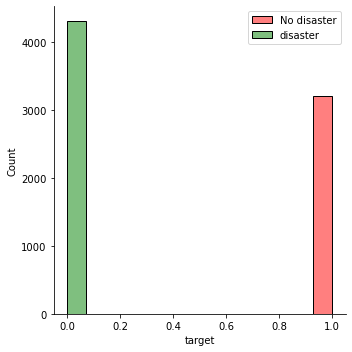

In [12]:
sns.displot(x = 'target', hue = 'target', data = train_df, palette = ['green', 'red'], legend = False)
plt.legend(['No disaster', 'disaster'])
plt.show()

## Target distribution based on keyword

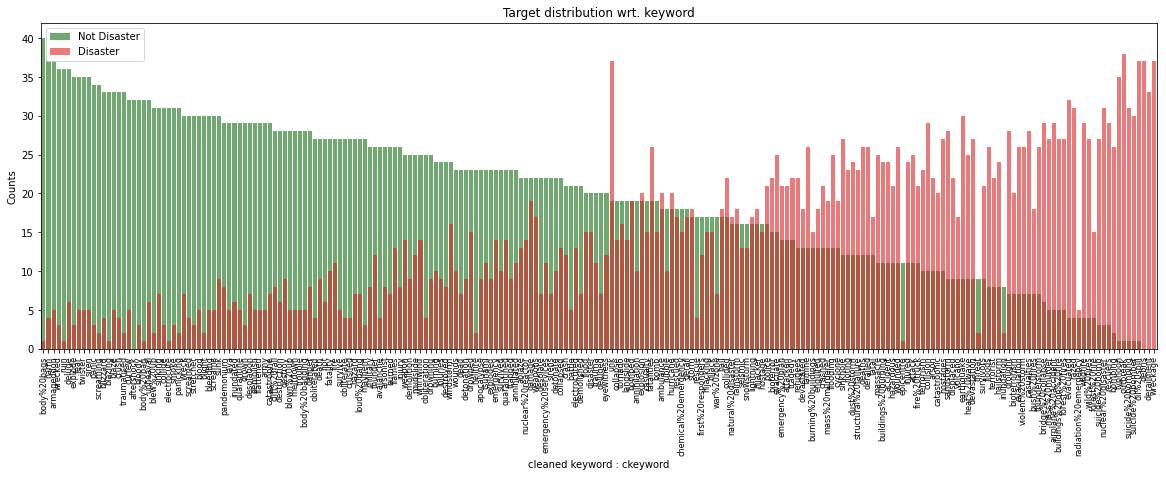

In [13]:
df = pd.pivot_table(train_df, index = ['keyword'], columns = ['target'], values = 'id', aggfunc = 'count', fill_value = 0 ).reset_index()
df = df.sort_values(by = [0], ascending = False)
plt.figure(figsize = (20, 6))
sns.barplot(y = 0, x = 'keyword', data = df, color = "g", alpha = 0.6, label = 'Not Disaster')
sns.barplot(y = 1, x = 'keyword', data = df, color = 'r', alpha = 0.6, label = 'Disaster')
plt.title('Target distribution wrt. keyword')
plt.xlabel('cleaned keyword : ckeyword')
plt.ylabel('Counts')
plt.xticks(rotation = 90, fontsize = 8)
plt.legend()

In [14]:
train_df['keyword'].value_counts()[0: 10]

unk            56
fatalities     45
armageddon     42
deluge         42
harm           41
body%20bags    41
damage         41
evacuate       40
fear           40
siren          40
Name: keyword, dtype: int64

## Target distribution based on Location

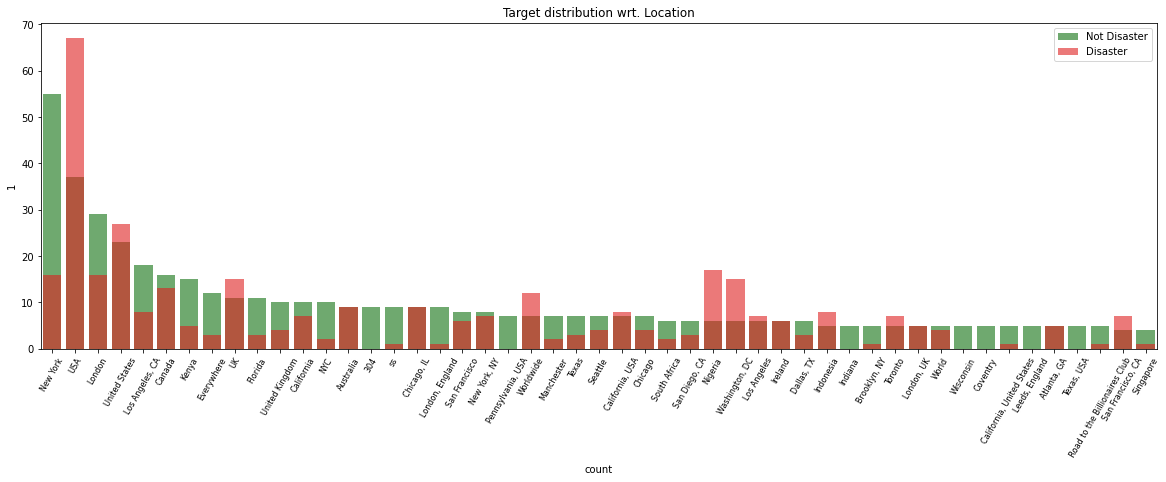

In [15]:
df = pd.pivot_table(train_df, index = 'location', columns = 'target', values = 'id', aggfunc = 'count', fill_value = 0).reset_index()
df = df.sort_values(by = 0, ascending = False)
lim = 50
plt.figure(figsize = (20, 6))
sns.barplot(x = 'location', y = 0, data = df.iloc[1:lim], color = 'g', alpha = 0.6, label = 'Not Disaster')
sns.barplot(x = 'location', y = 1, data = df.iloc[1:lim], color = 'r', alpha = 0.6, label = 'Disaster')
plt.xlabel('count')
plt.title('Target distribution wrt. Location')
plt.xticks(rotation = 60, fontsize = 8)
plt.legend()
plt.show()

In [16]:
# This is just to know that dataset contains various different locations & is diverse
train_df['location'].value_counts()[0:20]

unk                2482
USA                 104
New York             71
United States        50
London               45
Canada               29
Los Angeles, CA      26
UK                   26
Nigeria              23
India                21
Washington, DC       21
Kenya                20
Mumbai               20
Worldwide            19
Australia            18
Chicago, IL          18
California           17
New York, NY         15
California, USA      15
Everywhere           15
Name: location, dtype: int64

## Text Normalisation of tweets

In [17]:
# 'text' : inbuilt attribute of dataset
# 'ctext' : tweet text after cleaning

train_df['ctext'] = train_df['text'].copy()

def clean_txt(txt):
    # normalizing the text
    res = unicodedata.normalize('NFKC', txt)
    # remove non_printable characters
    res = re.sub(r'[^\x00-\x7F]+', r'', res)
    # remove retweet chars
    res = re.sub(r'^RT[\s]+', r'', res)
    # remove stock market tiker
    res = re.sub(r'\$\w*', r'', res)
    # replalce less, greater, and chars
    res = re.sub(r'&lt;', r'<', res)
    res = re.sub(r'&gt;', r'>', res)
    res = re.sub(r'&amp;?', r'and', res)
    # remove html tags
    res = re.sub(r'<[^>]*?>', r'', res)
    # separate contected hashtags
    res = re.sub(r'#', r' #', res)
    res = re.sub(r'\s#\s', r' ', res)
    return res

train_df['ctext'] = train_df['ctext'].apply(clean_txt )

### URL distribution visualisation

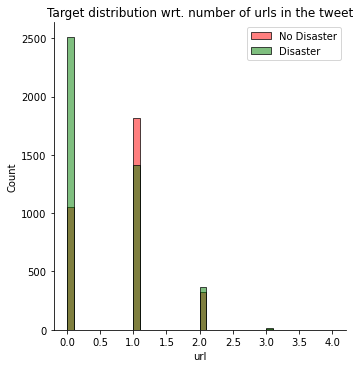

In [18]:
regex = r'http\S+|www\.\S+'
sub_str = r' website '
def apply_regex(txt, regex, sub_str):
    matches = re.findall(regex, txt)
    if matches:
        ctxt = re.sub(regex, sub_str, txt)
        return ctxt, len(matches)
    else:
        return txt, 0
res = train_df['ctext'].apply(apply_regex, args = [regex, sub_str],)
train_df['ctext'] = res.apply(lambda t:t[0])
train_df['url'] = res.apply(lambda t:t[1])
sns.displot(x = 'url', hue = 'target', data = train_df, palette = ['g', 'r'], kind = 'hist', legend = False)
plt.legend(['No Disaster', 'Disaster'])
plt.title('Target distribution wrt. number of urls in the tweet')
plt.show()
#print(train_df)

### Analysis of effect of having url in the tweet
* When people share no urls in the tweet, it is more likely to be not about a disastor
* When people share one url in the tweet, it is more likely to be about a disaster


### Hash tags and mentions

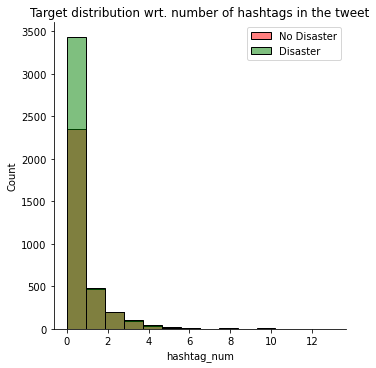

In [19]:
def validate_hashtag(hashtags):
    res = []
    for hashtag in hashtags:
        valid = re.findall(r'[a-zA-Z]+', hashtag)
        if valid:
            res.append(re.sub(r'[^\w]*', r'', hashtag).lower())
        else:
            res.append('unk')
    return res

def extract_hashtags(txt):
    regex = r'#+\s*\S+'
    hash_tag_matches = re.findall(regex, txt)
    if hash_tag_matches:
        ctxt = re.sub(r'#+\s*(?P<hash>\S+)', r'\g<hash>', txt)
        validated_hash = list(set(validate_hashtag(hash_tag_matches)))
        return ctxt, len(validated_hash), validated_hash
    else:
        return txt, 0, ['none']

res = train_df['ctext'].apply(extract_hashtags)
train_df['ctext'] = res.apply(lambda t:t[0])
train_df['hashtag_num'] = res.apply(lambda t:t[1])
train_df['hashtags'] = res.apply(lambda t:t[2])
sns.displot(x = 'hashtag_num', hue = 'target', data = train_df, palette = ['g', 'r'], kind = 'hist', legend = False)
plt.legend(['No Disaster', 'Disaster'])
plt.title('Target distribution wrt. number of hashtags in the tweet')
plt.show()
#print(train_df)

## How many words do exist in the dictionary

In [20]:
#print(train_df['ctext'].to_string())
txt = ' '.join(train_df.ctext.values)
txt = re.sub(r'[%s]' % re.escape(string.punctuation), r' ', txt)
txt = re.sub(r'\s+', r' ', txt)
tokens = set(txt.split())
word_dict = set(word_dict)
not_word_tokens = tokens - tokens.intersection(word_dict)

print(f'Tweets contain unknown words: {100 * len(not_word_tokens) / len(tokens):.2f}%')

Tweets contain unknown words: 71.64%


In [21]:
tokens = set([stemmer.stem(w) for w in txt.split()])
word_dict = set(word_dict)
not_word_tokens = tokens - tokens.intersection(word_dict)

print(f'After stemming! Tweets contain unknown words: {100 * len(not_word_tokens) / len(tokens):.2f}%')

After stemming! Tweets contain unknown words: 69.58%


In [22]:
list(not_word_tokens)[:15]

['postapocalypticflimflam',
 '1916',
 'sentenc',
 'bluedio',
 'natali',
 'goz',
 'dani',
 'emily4everev',
 'kororinpa',
 'episcop',
 'tallest',
 'reid',
 'kamayani',
 'epl',
 'rubberi']

Unknown word exists due to:
* stemming errors
* name of places
* name of persons
* mis-spelling
* concatenated words
* abbreviations

## DISASTER TWEETS CLEANING

In [23]:
!pip install beautifulsoup4
!pip install ekphrasis

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


## Import Libs

In [24]:
import requests, json
import string
import re
from itertools import chain

import numpy as np
import pandas as pd

from bs4 import BeautifulSoup

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from ekphrasis.dicts.noslang.slangdict import slangdict

from nltk.corpus import words
from nltk.corpus import stopwords
import spacy

nlp = spacy.load("en_core_web_sm")
en_words = words.words()
st_words = stopwords.words()

## Read data

In [26]:
# training data : 'df' and testing data : 'test_df'

#df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df = train_df
#test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
df_leak = pd.read_csv(r'C:/Users/korra prathyusha/Downloads\socialmedia-disaster-tweets-DFE.csv',  encoding ='ISO-8859-1')
df_leak['target'] = (df_leak['choose_one'] == 'Relevant').astype(np.int8)
df_leak['id'] = df_leak.index.astype(np.int16)
df_leak = df_leak[['target', 'id']]
test_df = test_df.merge(df_leak, on=['id'], how='left')

print(df.shape, test_df.shape)

(7503, 9) (3263, 5)


## Util Functions


In [27]:
def get_unk_words(txts):
    txt = ' '.join(txts)
    doc = nlp(txt)
    tokens = set([tok.lemma_ for tok in doc])

    word_dict = set([tok.lower() for tok in en_words])
    not_word_tokens = tokens - tokens.intersection(word_dict)
    print('Vocabs size', len(tokens))
    print('Unknown vocabs size', len(not_word_tokens))
    print(f'Tweets contain unknown words: {100 * len(not_word_tokens) / len(tokens):.2f}%')
    return not_word_tokens

## Chat Abbreviations

In [28]:
pairs =  list(slangdict.items())
for i in range(10):
    print(pairs[i])

uncased_slang_dict = {}
for key, value in slangdict.items():
    value = re.sub(r'it means', '', value)
    value = re.sub(r'\*\*\*', 'uck', value)
    value = re.sub(r'\*\*', 'it', value)
    value = re.sub(r'it refers to', '', value)
    uncased_slang_dict[key.lower()] = value.lower()

print()
print('Slang Words Count:', len(uncased_slang_dict))
print()

replacement_patterns = [
    (r'won\'t', 'will not'),
    (r'can\'t', 'cannot'),
    (r'i\'m', 'i am'),
    (r'I\'m', 'I am'),
    (r'ain\'t', 'is not'),
    (r'(\w+)\'ll', '\g<1> will'),
    (r'(\w+)n\'t', '\g<1> not'),
    (r'(\w+)\'ve', '\g<1> have'),
    (r'(\w+)\'s', '\g<1> is'),
    (r'(\w+)\'re', '\g<1> are'),
    (r'(\w+)\'d', '\g<1> would'),
]

abbr = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired",
    "yr": "year",
    "u.s":"usa",
}

def replace_slang(txt, slang):
    ctxt = re.sub(r'\s+', ' ', txt)
    res = []
    for tok in ctxt.split():
        if tok.lower() in slang:
            res.append(slang[tok.lower()])
        else:
            res.append(tok)
    res = ' '.join(res)
    return res.strip()

sent = 'I want to go aamof home'
print(sent)
print(replace_slang(sent, abbr))

('*4u', 'Kiss for you')
('*67', 'unknown')
('*eg*', 'evil grin')
('07734', 'hello')
('0day', 'software illegally obtained before it was released')
('0noe', 'Oh No')
('0vr', 'over')
('10q', 'thank you')
('10tacle', 'tentacle')
('10x', 'thanks')

Slang Words Count: 5429

I want to go aamof home
I want to go as a matter of fact home


## Define text preprocessor
* extract emojis
* replace numbers/date/money
* extract hashtags
* correct enlongated/repeated character

In [29]:
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize = ['rest_emoticons', 'rtl_face', 'cashtag','url',
                 'email', 'percent', 'money', 'phone', 'user', 
                 'time', 'date', 'number', 'eastern_emoticons'],
    # terms that will be annotated
    annotate = set(["elongated", "repeated"]),
    fix_html = True,  # fix HTML tokens
    segmenter="twitter", 
    corrector = "twitter", 
    unpack_hashtags = True,  # perform word segmentation on hashtags
    unpack_contractions = True,  # Unpack contractions (can't -> can not)
    spell_correct_elong = False,  # spell correction for elongated words
    tokenizer=SocialTokenizer(lowercase=False).tokenize,
    dicts=[emoticons]
)

C:\Users\korra prathyusha\AppData\Roaming\Python\Python39\site-packages\ekphrasis\classes\tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


C:\Users\korra prathyusha\AppData\Roaming\Python\Python39\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


## Text Cleaning

In [30]:
def preprocess(txt):
    # remove non-ascii characters
    res = txt.encode('ascii', 'ignore').decode()
    # replace slang token if the token is not an english word
    res = replace_slang(res, uncased_slang_dict)
    # replace shorten pattern i.e I'll--> I will
    for patt, rep in replacement_patterns:
        res = re.sub(patt, rep, res)
    # Extract emojis and hashtags and segment the txt
    res = ' '.join(text_processor.pre_process_doc(res)).strip()
    for patt in [r"<elongated>", r"<repeated>"]:
        res = re.sub(patt, '', res)
        
    # another try to replace the slangs after segmentation
    res = replace_slang(res, uncased_slang_dict)

    # remove punctuaions
    res = re.sub(r'[%s]' % re.escape(''.join(string.punctuation)), r' ',res)
    # lower case
    res = res.lower()
    # remove consecutive duplicated tokens
    res = re.sub(r'\b(\w+)(?:\W+\1\b)+', r'\1', res)
    #remove extra spaces
    res = re.sub(r'\s+', ' ', res)
    return res.strip()

In [31]:
df['ctext'] = df['text'].apply(preprocess)
test_df['ctext'] = test_df['text'].apply(preprocess)

## Pre-Processing Results

In [35]:
for txt, ctxt in df[['text', 'ctext']].values[0:10]:
    print('Plain tweet text: ',txt)
    print()
    print('Cleaned tweet text: ', ctxt)
    print()

Plain tweet text:  ! Residents Return To Destroyed Homes As Washington Wildfire Burns on http://t.co/UcI8stQUg1

Cleaned tweet text:  residents return to destroyed homes as washington wildfire burns on url

Plain tweet text:  # handbags Genuine Mulberry Antony Cross Body Messenger Bag Dark Oak Soft Buffalo Leather:  å£279.00End Date: W... http://t.co/FTM4RKl8mN

Cleaned tweet text:  handbags genuine mulberry antony cross body messenger bag dark oak soft buffalo leather number 0 end date w url

Plain tweet text:  #360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/9Naw3QOQOL

Cleaned tweet text:  360 wise news china is stock market crash are there gems in the rubble url

Plain tweet text:  #360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/aOd2ftBMGU

Cleaned tweet text:  360 wise news china is stock market crash are there gems in the rubble url

Plain tweet text:  #360WiseNews : China's Stock Market Crash: Are There Gem

In [36]:
not_word_tokens = get_unk_words(df['ctext'])
print()
not_word_tokens = get_unk_words(test_df['ctext'])

Vocabs size 11303
Unknown vocabs size 4135
Tweets contain unknown words: 36.58%

Vocabs size 7134
Unknown vocabs size 2213
Tweets contain unknown words: 31.02%


## Unknown Words

In [37]:
for tok in list(not_word_tokens)[0:20]:
    print(tok)

momentsathill
wozni
holmes
noticias
guyana
manipur
bickford
slix
otrametlife
a27
bracelet10
sosa
coahuila
kanos
e7
ballina
runion
pqhaxp
woulda
pref


## Remove duplicated texts

In [38]:
df = df.fillna('unk')
test_df = test_df.fillna('unk')

df = df.groupby(by = ['ctext']).agg({
    'id': 'first',
    'location': lambda x:x.value_counts().index[0],
    'keyword':lambda x:x.value_counts().index[0],
    'target': lambda x:x.value_counts().index[0],
    'text': lambda x:x.value_counts().index[0],
}).reset_index()

print(df.shape)

(6861, 6)


## Clean column keywords
* remove strang characters
* replace words with their lemma

In [39]:
def preprocess_keywords(txt):
    res = txt.lower()
    res = re.sub(r'[^a-zA-Z]', r' ', res)
    res = re.sub(r'\s+', r' ', res)
    doc = nlp(res)
    res = ' '.join([token.lemma_ for token in doc])
    res = re.sub(r'\s+', r' ', res)
    return res.strip()

In [40]:
keyword = set(df['keyword'].values)
keyword = {
    key: preprocess_keywords(key).lower() for key in keyword
}
    
df['ckeyword'] = df['keyword'].apply(lambda txt: keyword[txt])
test_df['ckeyword'] = test_df['keyword'].apply(lambda txt: keyword[txt])

In [41]:
df[df['keyword']!='unk'][['keyword', 'ckeyword']]

,keyword,ckeyword
0,quarantined,quarantine
1,sinkhole,sinkhole
2,outbreak,outbreak
3,suicide%20bomb,suicide bomb
4,suicide%20bomb,suicide bomb
...,...,...
6856,war%20zone,war zone
6857,electrocuted,electrocute
6858,flattened,flatten
6859,flattened,flatten


## Fix misclassified target

In [42]:
ids = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]

df.loc[df['id'].isin(ids), 'target'] = 0

In [43]:
df.to_csv('df.csv', index = False)
test_df.to_csv('test_df.csv', index = False)

# Model Training

In [45]:
! pip install --upgrade tensorflow protobuf


Defaulting to user installation because normal site-packages is not writeable
  Using cached protobuf-5.26.1-cp39-cp39-win_amd64.whl (420 kB)
  Using cached protobuf-4.25.3-cp39-cp39-win_amd64.whl (413 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.25.1 requires google-auth<2.0dev,>=1.21.1, but you have google-auth 2.27.0 which is incompatible.



  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl (2.4 kB)
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0


### 1. LSTM MODEL

In [46]:
import tensorflow as tf 
from tensorflow.keras import layers

X = df['ctext'].to_numpy()
y = df['target'].to_numpy()

X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 random_state=42, 
                                                 test_size=0.2)

ModuleNotFoundError: No module named 'tensorflow.python.distribute.distribution_strategy_context'

In [ ]:
MAX_TOKENS = 20_000
EMBEDDING_SIZE = 64

In [ ]:
#! pip install tensorflow --upgrade
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=MAX_TOKENS)
text_vectorizer.adapt(X)

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = layers.Embedding(MAX_TOKENS, EMBEDDING_SIZE)(x)
x = layers.Bidirectional(layers.LSTM(64,activation='relu',return_sequences=True))(x)
x = layers.LSTM(32,activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)



In [ ]:
model = tf.keras.models.Model(inputs, outputs)

model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics = ['accuracy'])
history = model.fit(X_train,y_train,
          validation_data = (X_test,y_test),
          epochs = 10)

In [ ]:
plt.plot(history.history['val_accuracy'],'r',label='val_acc')
plt.plot(history.history['accuracy'],'b',label='train_acc')
plt.legend()

In [ ]:
print('Accuracy of LSTM Model :')
model.evaluate(X_test,y_test)

### 2. BERT Model

#### Necessary Imports

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers as tfm

#### Helper Functions

In [ ]:
def encode(texts, tokenizer, max_len=64):
    tokens = tokenizer.batch_encode_plus(
        texts, max_length=max_len, pad_to_max_length=True
    )
    return np.array(tokens['input_ids'])

In [ ]:
def build_model(transformer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

### Configure TPU and define constants

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

# Create strategy from tpu
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

#### DATA LOADING

In [ ]:
MODEL_DIR = "/kaggle/input/huggingface-bert/"
EPOCHS = 12
MAX_LEN = 64
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [ ]:
# train data : 80% & validation data : 20%
train, valid = train_test_split(df, train_size=0.80, random_state=42)
test = test_df
tokenizer = tfm.BertTokenizerFast.from_pretrained(MODEL_DIR + 'bert-large-uncased')

train_input = encode(train.ctext.tolist(), tokenizer, max_len=MAX_LEN)
valid_input = encode(valid.ctext.tolist(), tokenizer, max_len=MAX_LEN)
test_input = encode(test.ctext.tolist(), tokenizer, max_len=MAX_LEN)

train_labels = train.target.values
valid_labels = valid.target.values

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_input, train_labels))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_input, valid_labels))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

### Load model & train

In [ ]:
%%time
with strategy.scope():
    transformer_layer = tfm.TFBertModel.from_pretrained(MODEL_DIR + 'bert-large-uncased')
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

In [ ]:
N_STEPS = train_input.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=N_STEPS,
    epochs=EPOCHS,
    validation_data=valid_dataset
)

### visualization

In [ ]:
plt.plot(train_history.history['loss'], label='train')
plt.plot(train_history.history['val_loss'], label='test')
plt.legend()
plt.show()